### Starting the Project

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import chardet
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from imblearn.combine import SMOTEENN
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils import resample
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

### Reading the file in binary mode

In [2]:
with open('customer_booking.csv', 'rb') as file:
    raw_data = file.read()

# Detecting the file encoding
result = chardet.detect(raw_data)
encoding = result['encoding']
print(f"Encoding is : {encoding}")

Encoding is : ISO-8859-1


### Reading the file with the detected encoding

In [3]:
df = pd.read_csv('customer_booking.csv', encoding=encoding)
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


### Exploratory Data Analysis

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

### Segregating the Object type and Numerical Type features in order to make them more correlated with the target variable.

In [5]:
object_col = df.select_dtypes(include=['object'])

In [6]:
object_col.head(5)

,sales_channel,trip_type,flight_day,route,booking_origin
0,Internet,RoundTrip,Sat,AKLDEL,New Zealand
1,Internet,RoundTrip,Sat,AKLDEL,New Zealand
2,Internet,RoundTrip,Wed,AKLDEL,India
3,Internet,RoundTrip,Sat,AKLDEL,New Zealand
4,Internet,RoundTrip,Wed,AKLDEL,India


In [7]:
numeric_col = df.select_dtypes(include=['number'])

In [8]:
numeric_col.head(5)

,num_passengers,purchase_lead,length_of_stay,flight_hour,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,262,19,7,1,0,0,5.52,0
1,1,112,20,3,0,0,0,5.52,0
2,2,243,22,17,1,1,0,5.52,0
3,1,96,31,4,0,0,1,5.52,0
4,2,68,22,15,1,0,1,5.52,0


In [9]:
target = pd.DataFrame(numeric_col["booking_complete"])
target.head(5)

,booking_complete
0,0
1,0
2,0
3,0
4,0


In [10]:
object_col = pd.concat([object_col, target], axis = 1)

In [11]:
object_col.head()

,sales_channel,trip_type,flight_day,route,booking_origin,booking_complete
0,Internet,RoundTrip,Sat,AKLDEL,New Zealand,0
1,Internet,RoundTrip,Sat,AKLDEL,New Zealand,0
2,Internet,RoundTrip,Wed,AKLDEL,India,0
3,Internet,RoundTrip,Sat,AKLDEL,New Zealand,0
4,Internet,RoundTrip,Wed,AKLDEL,India,0


In [12]:
object_col["sales_channel"].unique()

array(['Internet', 'Mobile'], dtype=object)

In [13]:
object_col["trip_type"].unique()

array(['RoundTrip', 'CircleTrip', 'OneWay'], dtype=object)

In [14]:
object_col["flight_day"].unique()

array(['Sat', 'Wed', 'Thu', 'Mon', 'Sun', 'Tue', 'Fri'], dtype=object)

In [15]:
object_col["route"].unique()

array(['AKLDEL', 'AKLHGH', 'AKLHND', 'AKLICN', 'AKLKIX', 'AKLKTM',
       'AKLKUL', 'AKLMRU', 'AKLPEK', 'AKLPVG', 'AKLTPE', 'AORICN',
       'AORKIX', 'AORKTM', 'AORMEL', 'BBIMEL', 'BBIOOL', 'BBIPER',
       'BBISYD', 'BDOCTS', 'BDOCTU', 'BDOHGH', 'BDOICN', 'BDOIKA',
       'BDOKIX', 'BDOMEL', 'BDOOOL', 'BDOPEK', 'BDOPER', 'BDOPUS',
       'BDOPVG', 'BDOSYD', 'BDOTPE', 'BDOXIY', 'BKICKG', 'BKICTS',
       'BKICTU', 'BKIHND', 'BKIICN', 'BKIKIX', 'BKIKTM', 'BKIMEL',
       'BKIMRU', 'BKIOOL', 'BKIPEK', 'BKIPER', 'BKIPUS', 'BKIPVG',
       'BKISYD', 'BKIXIY', 'BLRICN', 'BLRMEL', 'BLRPER', 'BLRSYD',
       'BOMMEL', 'BOMOOL', 'BOMPER', 'BOMSYD', 'BTJJED', 'BTUICN',
       'BTUPER', 'BTUSYD', 'BTUWUH', 'BWNCKG', 'BWNDEL', 'BWNHGH',
       'BWNIKA', 'BWNKTM', 'BWNMEL', 'BWNOOL', 'BWNPER', 'BWNSYD',
       'BWNTPE', 'CANDEL', 'CANIKA', 'CANMEL', 'CANMRU', 'CANOOL',
       'CANPER', 'CANSYD', 'CCUMEL', 'CCUMRU', 'CCUOOL', 'CCUPER',
       'CCUSYD', 'CCUTPE', 'CEBMEL', 'CEBOOL', 'CEBPER', 'CEBS

In [16]:
object_col["booking_origin"].unique()

array(['New Zealand', 'India', 'United Kingdom', 'China', 'South Korea',
       'Japan', 'Malaysia', 'Singapore', 'Switzerland', 'Germany',
       'Indonesia', 'Czech Republic', 'Vietnam', 'Thailand', 'Spain',
       'Romania', 'Ireland', 'Italy', 'Slovakia', 'United Arab Emirates',
       'Tonga', 'Réunion', '(not set)', 'Saudi Arabia', 'Netherlands',
       'Qatar', 'Hong Kong', 'Philippines', 'Sri Lanka', 'France',
       'Croatia', 'United States', 'Laos', 'Hungary', 'Portugal',
       'Cyprus', 'Australia', 'Cambodia', 'Poland', 'Belgium', 'Oman',
       'Bangladesh', 'Kazakhstan', 'Brazil', 'Turkey', 'Kenya', 'Taiwan',
       'Brunei', 'Chile', 'Bulgaria', 'Ukraine', 'Denmark', 'Colombia',
       'Iran', 'Bahrain', 'Solomon Islands', 'Slovenia', 'Mauritius',
       'Nepal', 'Russia', 'Kuwait', 'Mexico', 'Sweden', 'Austria',
       'Lebanon', 'Jordan', 'Greece', 'Mongolia', 'Canada', 'Tanzania',
       'Peru', 'Timor-Leste', 'Argentina', 'New Caledonia', 'Macau',
       'Myanmar (

#### Since, the Route and Booking Origin features contains too much values which make it difficult to process. So, we'll be eliminating these features from our dataset.

In [17]:
object_col = object_col.drop(['route','booking_origin'], axis = 1)

In [18]:
object_col.head()

,sales_channel,trip_type,flight_day,booking_complete
0,Internet,RoundTrip,Sat,0
1,Internet,RoundTrip,Sat,0
2,Internet,RoundTrip,Wed,0
3,Internet,RoundTrip,Sat,0
4,Internet,RoundTrip,Wed,0


#### Now, we'll change the categorical data into the numerica data

In [19]:
mappings = {
    
    'Sat':0,
    'Sun':1,
    'Mon':2,
    'Tue':3,
    'Wed':4,
    'Thu':5,
    'Fri':6,
    
}
object_col["flight_day"] = object_col["flight_day"].map(mappings)

In [20]:
object_col.head()

,sales_channel,trip_type,flight_day,booking_complete
0,Internet,RoundTrip,0,0
1,Internet,RoundTrip,0,0
2,Internet,RoundTrip,4,0
3,Internet,RoundTrip,0,0
4,Internet,RoundTrip,4,0


In [21]:
object_col["sales_channel"] = object_col["sales_channel"].replace('Internet',0)
object_col["sales_channel"] = object_col["sales_channel"].replace('Mobile',1)

In [22]:
object_col["trip_type"] = object_col["trip_type"].replace('RoundTrip',0)
object_col["trip_type"] = object_col["trip_type"].replace('CircleTrip',1)
object_col["trip_type"] = object_col["trip_type"].replace('OneWay',2)

In [23]:
cor_mt_ob = object_col.corr()
cor_mt_ob["booking_complete"].sort_values(ascending = False)

booking_complete    1.000000
flight_day          0.005313
trip_type          -0.027215
sales_channel      -0.041060
Name: booking_complete, dtype: float64

In [24]:
numeric_col.nunique()

num_passengers             9
purchase_lead            470
length_of_stay           335
flight_hour               24
wants_extra_baggage        2
wants_preferred_seat       2
wants_in_flight_meals      2
flight_duration           21
booking_complete           2
dtype: int64

### Now, Looking for the correlations 

booking_complete         1.000000
wants_extra_baggage      0.068139
wants_preferred_seat     0.050116
wants_in_flight_meals    0.026511
num_passengers           0.024116
flight_hour              0.007127
purchase_lead           -0.022131
length_of_stay          -0.042408
flight_duration         -0.106266
Name: booking_complete, dtype: float64


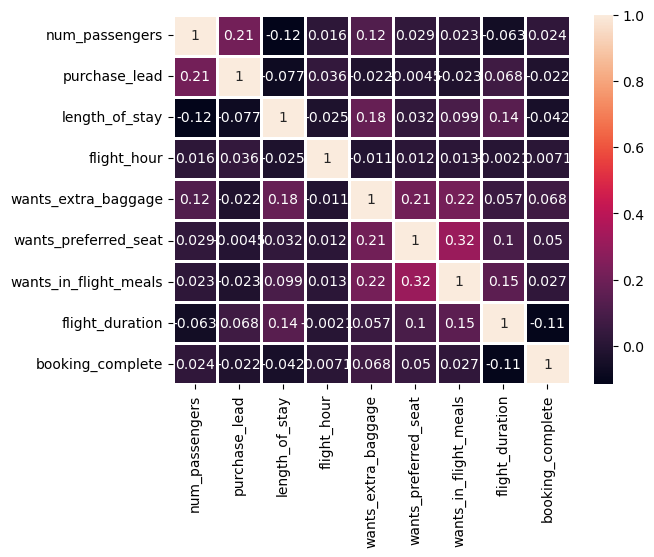

In [25]:
c_mat = numeric_col.corr()
print(c_mat["booking_complete"].sort_values(ascending = False))
plt.figsize = (10,8)
sns.heatmap(c_mat, annot = True, linewidths=2)
plt.show()

#### Now, checking for some outliers

In [26]:
numeric_col.columns

Index(['num_passengers', 'purchase_lead', 'length_of_stay', 'flight_hour',
       'wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals',
       'flight_duration', 'booking_complete'],
      dtype='object')

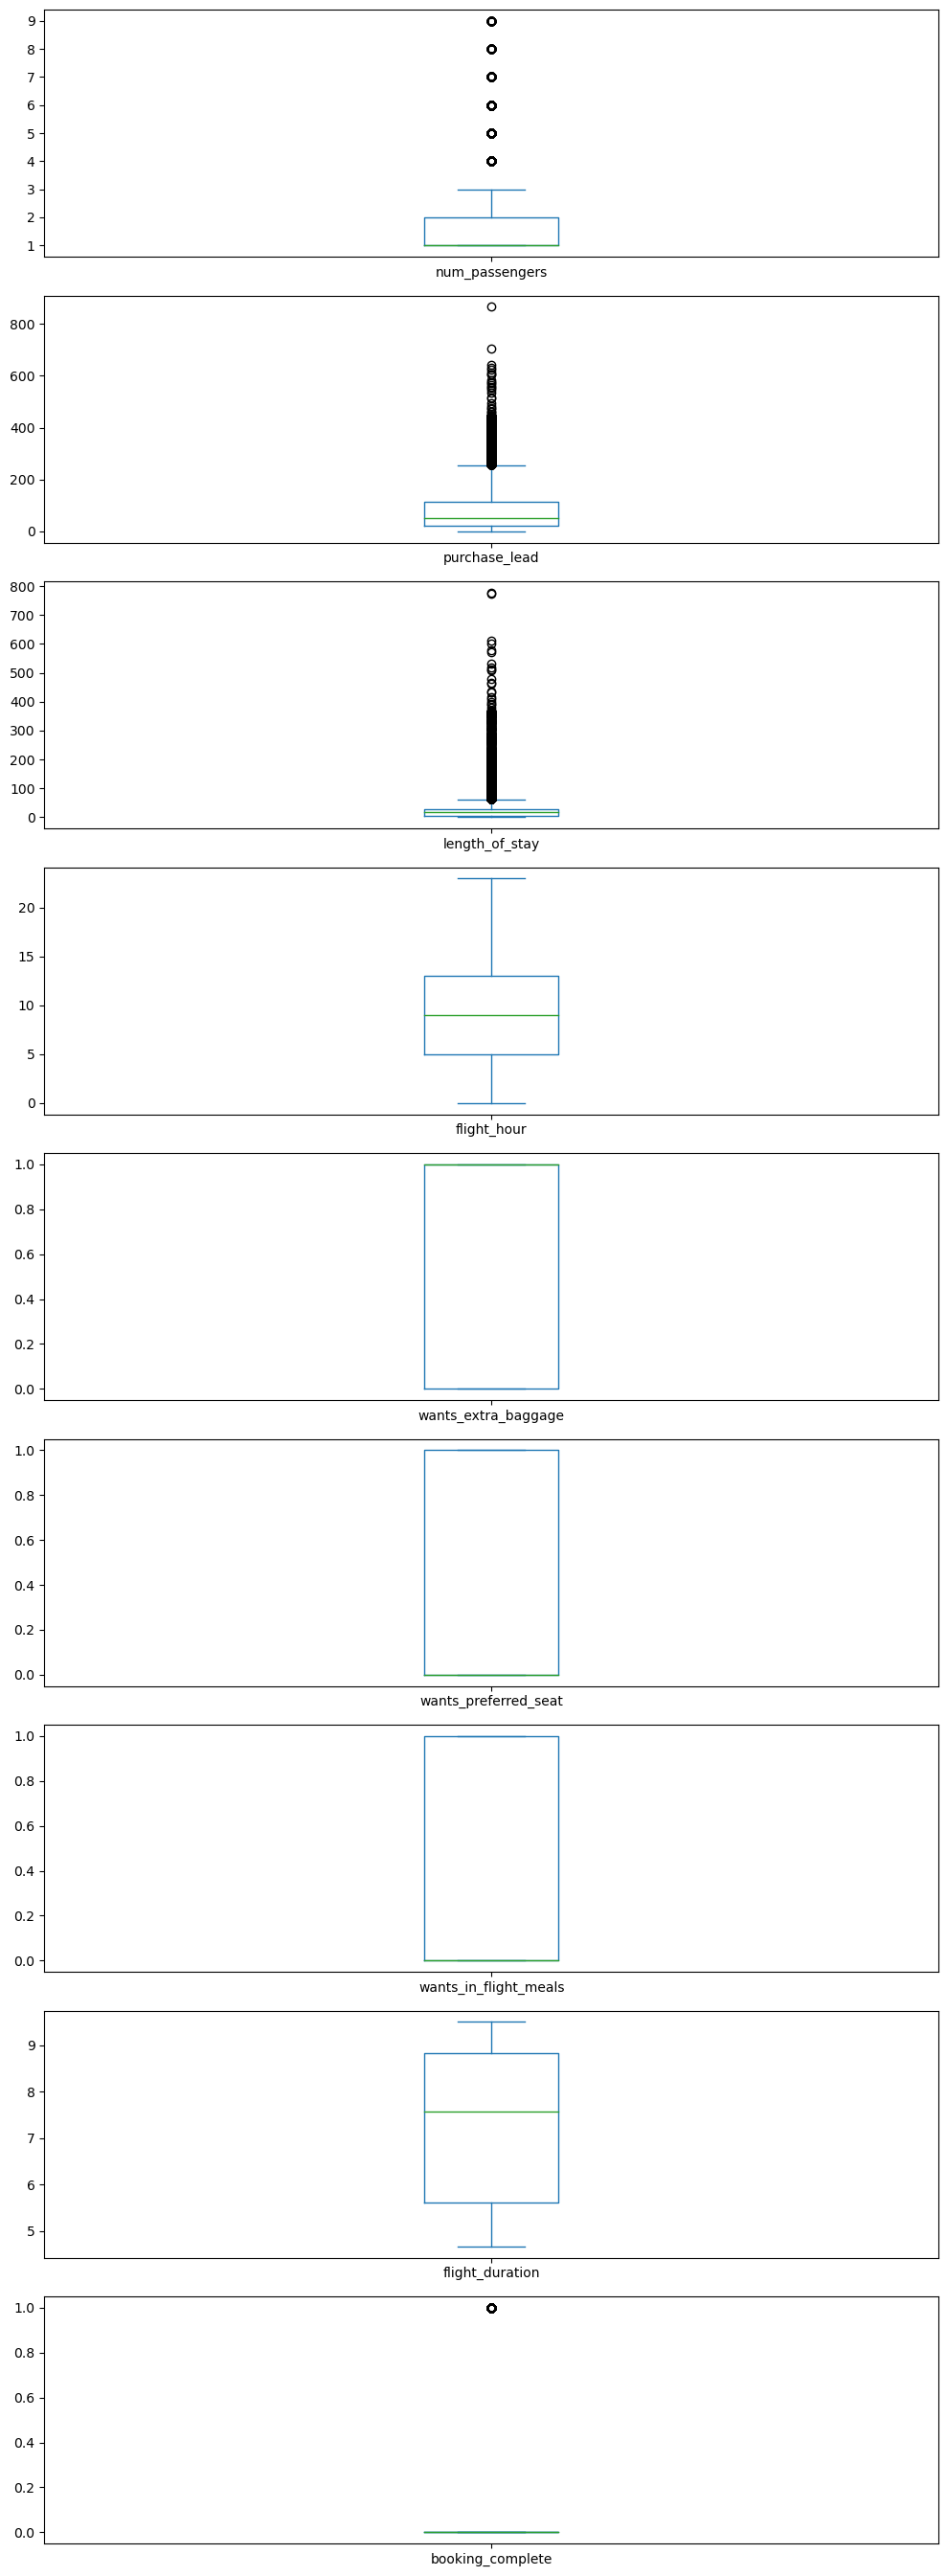

In [27]:
numeric_col.plot(kind='box', subplots=True, layout=(len(numeric_col.columns), 1), figsize=(10, len(numeric_col.columns) * 3), sharex=False, sharey=False)
plt.tight_layout()
plt.show()

<Axes: >

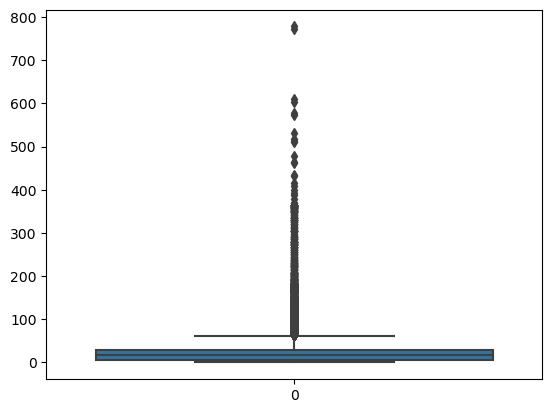

In [28]:
sns.boxplot(numeric_col['length_of_stay'])

### Since, the dataset is imbalanced. So, we'll be using UPSAMPLING to make it balanced. Then, we'll proceed towards its training.

In [29]:
numeric_col['booking_complete'].value_counts()

0    42522
1     7478
Name: booking_complete, dtype: int64

In [30]:
numeric_col = numeric_col.drop(['wants_in_flight_meals','wants_preferred_seat','wants_extra_baggage'], axis = 1)

In [31]:
#create two different dataframe of majority and minority class 
df_majority = numeric_col[(numeric_col['booking_complete']==0)] 
df_minority = numeric_col[(numeric_col['booking_complete']==1)] 
# upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,    # sample with replacement
                                 n_samples= 42522, # to match majority class
                                 random_state=42)  # reproducible results

# Combine majority class with upsampled minority class
final_df = pd.concat([df_minority_upsampled, df_majority])

In [32]:
final_df['booking_complete'].value_counts()

1    42522
0    42522
Name: booking_complete, dtype: int64

### Model Training and Testing


In [33]:
x = final_df.drop('booking_complete', axis = 1)
y = final_df['booking_complete']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25)

### Looking for the best performing model

#### Random Forest Classifier

In [34]:
rfc = RandomForestClassifier(n_estimators=200)
rfc.fit(x_train, y_train)
y_pred = rfc.predict(x_test)

In [35]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9346220779831617
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.88      0.93     10589
           1       0.90      0.99      0.94     10672

    accuracy                           0.93     21261
   macro avg       0.94      0.93      0.93     21261
weighted avg       0.94      0.93      0.93     21261



#### Decision Tree Classifier

In [36]:
dct = DecisionTreeClassifier()
dct.fit(x_train, y_train)
y_pred = dct.predict(x_test)

In [37]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.9040026339306712
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.82      0.90     10589
           1       0.85      0.98      0.91     10672

    accuracy                           0.90     21261
   macro avg       0.92      0.90      0.90     21261
weighted avg       0.91      0.90      0.90     21261



#### Naive Bayes 

In [38]:
nb = GaussianNB()
nb.fit(x_train, y_train)
y_pred = nb.predict(x_test)

In [39]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.5690230939278491
Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.59      0.57     10589
           1       0.57      0.55      0.56     10672

    accuracy                           0.57     21261
   macro avg       0.57      0.57      0.57     21261
weighted avg       0.57      0.57      0.57     21261



### Logistic Regression

In [40]:
lr = LogisticRegression()
lr.fit(x_train, y_train)
y_pred = lr.predict(x_test)

In [41]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.5710926108837778
Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.56      0.57     10589
           1       0.57      0.58      0.58     10672

    accuracy                           0.57     21261
   macro avg       0.57      0.57      0.57     21261
weighted avg       0.57      0.57      0.57     21261



#### Gradient Boosting Classifier

In [42]:
gb_clf = GradientBoostingClassifier(random_state=42)
gb_clf.fit(x_train, y_train)
y_pred = gb_clf.predict(x_test)

In [43]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.6274399134565637
Classification Report:
               precision    recall  f1-score   support

           0       0.64      0.59      0.61     10589
           1       0.62      0.66      0.64     10672

    accuracy                           0.63     21261
   macro avg       0.63      0.63      0.63     21261
weighted avg       0.63      0.63      0.63     21261



#### AdaBoost Classifier and Voting Classifier

In [44]:
dt_clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), random_state=42)
rf_clf = RandomForestClassifier(random_state=42)

# Initialize voting classifier with soft voting
voting_clf = VotingClassifier(
    estimators=[('dt', dt_clf), ('rf', rf_clf)],
    voting='soft'  # 'soft' for probability voting, 'hard' for majority voting
)

# Fit the voting classifier on the training data
voting_clf.fit(x_train, y_train)

# Make predictions on the testing data
y_pred = voting_clf.predict(x_test)

D:\anaconda\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


In [45]:
# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Voting Classifier Accuracy: {accuracy:.2f}')
print("Classification Report:\n", classification_report(y_test, y_pred))

Voting Classifier Accuracy: 0.93
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.87      0.92     10491
           1       0.89      0.99      0.93     10770

    accuracy                           0.93     21261
   macro avg       0.94      0.93      0.93     21261
weighted avg       0.94      0.93      0.93     21261



### Stacking with Decision Tree and Logistic Regression

In [46]:
dt_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', AdaBoostClassifier(base_estimator=DecisionTreeClassifier(), random_state=42))
])

lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', AdaBoostClassifier(base_estimator=LogisticRegression(), random_state=42))
])

# Parameter grid for Decision Tree
dt_param_grid = {
    'clf__n_estimators': [50, 100],
    'clf__learning_rate': [0.01, 0.1, 1.0],
    'clf__base_estimator__max_depth': [1, 2, 3]
}

# Parameter grid for Logistic Regression
lr_param_grid = {
    'clf__n_estimators': [50, 100],
    'clf__learning_rate': [0.01, 0.1, 1.0],
    'clf__base_estimator__C': [0.1, 1.0, 10.0]
}

# Perform GridSearchCV for Decision Tree
dt_grid_search = GridSearchCV(dt_pipeline, dt_param_grid, cv=5, n_jobs=-1)
dt_grid_search.fit(x_train, y_train)
dt_best_estimator = dt_grid_search.best_estimator_

# Perform GridSearchCV for Logistic Regression
lr_grid_search = GridSearchCV(lr_pipeline, lr_param_grid, cv=5, n_jobs=-1)
lr_grid_search.fit(x_train, y_train)
lr_best_estimator = lr_grid_search.best_estimator_

# Create a Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=[('dt', dt_best_estimator), ('lr', lr_best_estimator)],
    final_estimator=LogisticRegression()
)

# Fit the Stacking Classifier on the training data
stacking_clf.fit(x_train, y_train)


# Make predictions on the testing data
stacking_y_pred = stacking_clf.predict(x_test)

D:\anaconda\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
D:\anaconda\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
D:\anaconda\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
D:\anaconda\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
D:\anaconda\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
D:\anaconda\lib\site-packages\sklearn\ensemble\_base.py:166: FutureWarning: `base_estimator` was ren

In [47]:
# Calculate the accuracy
stacking_accuracy = accuracy_score(y_test, stacking_y_pred)

print(f'Stacking Classifier Accuracy: {stacking_accuracy:.2f}')
print("Classification Report:\n", classification_report(y_test, y_pred))

Stacking Classifier Accuracy: 0.65
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.87      0.92     10491
           1       0.89      0.99      0.93     10770

    accuracy                           0.93     21261
   macro avg       0.94      0.93      0.93     21261
weighted avg       0.94      0.93      0.93     21261



### Checking for Feature Importances

In [46]:
feature_importances = rfc.feature_importances_
features = x.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)


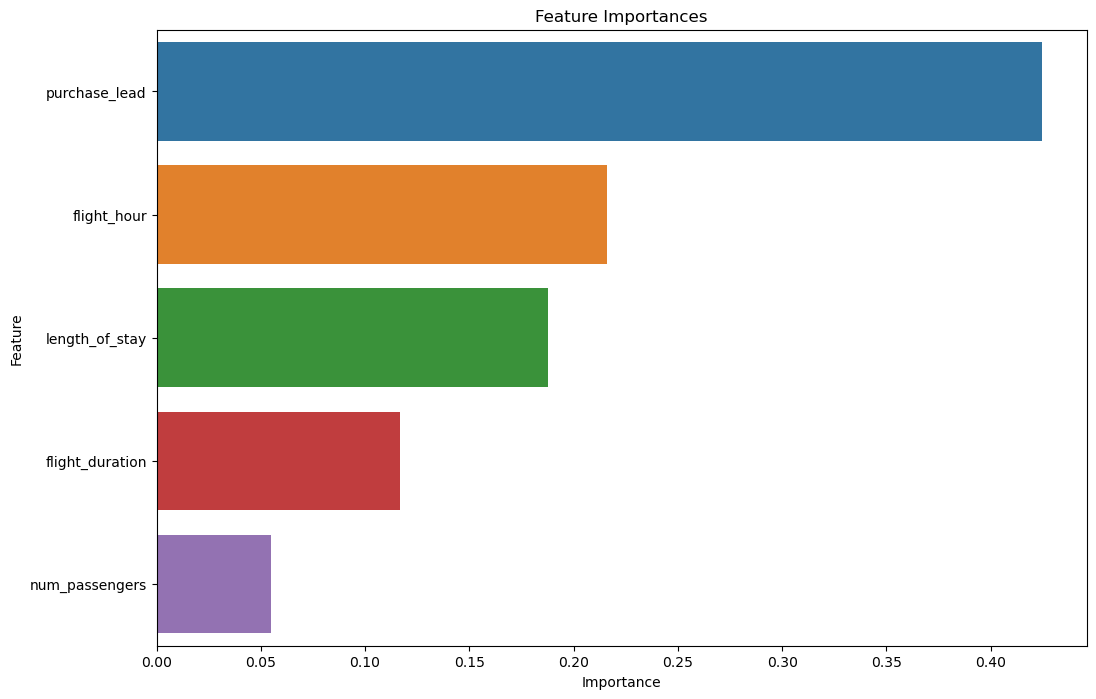

In [47]:
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importances')
plt.show()


In [48]:
importance_df

,Feature,Importance
1,purchase_lead,0.424736
3,flight_hour,0.215787
2,length_of_stay,0.187761
4,flight_duration,0.116734
0,num_passengers,0.054981


### Creating Pipeline

In [48]:
# Define preprocessing steps
preprocessor = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),  # Impute missing values with mean
    ('scaler', StandardScaler())  # Standardize features
])

In [49]:
# Define the pipeline with preprocessing and classifier
pipeline = Pipeline([
    ('preprocessor', preprocessor),  # Preprocessing steps
    ('classifier', RandomForestClassifier(random_state=42))  # Classifier
])

In [50]:
pipeline.fit(x_train, y_train)
y_pred = pipeline.predict(x_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.93
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.88      0.93     10491
           1       0.90      0.99      0.94     10770

    accuracy                           0.93     21261
   macro avg       0.94      0.93      0.93     21261
weighted avg       0.94      0.93      0.93     21261



### Now, we'll be making this model ready for deployment.

In [51]:
from joblib import dump,load
dump(rfc, 'Dragon.joblib')

['Dragon.joblib']

In [52]:
from joblib import dump, load
rfc = load('Dragon.joblib')

In [53]:
x_train.head(1)

,num_passengers,purchase_lead,length_of_stay,flight_hour,flight_duration
45985,2,10,6,7,5.07


In [54]:
y_train.head(1)

45985    1
Name: booking_complete, dtype: int64

###### Testing

In [58]:
feature = np.array([[2,10,6,7,5.07]])

In [59]:
def check_booking(feature):
    try:
        booking = rfc.predict(feature)
        if booking == 1:
            print('BOOKING CONFIRMED')
        elif booking == 0:
            print('BOOKING NOT CONFIRMED')
    except ValueError as e:
        print('Give more input')

In [60]:
check_booking(feature)

BOOKING CONFIRMED


D:\anaconda\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


#### Performing Perfectly